In [1]:
# Setup access to my Google Drive
from google.colab import drive
drive.mount('/content/drive',  force_remount=False)

# Set the working directory
import os
os.chdir('/content/drive/MyDrive/ViT_myWorks/')
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [2]:
!pip install -q torchmetrics
!pip install --upgrade pytorch-pretrained-vit
!pip install efficientnet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-pretrained-vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11116 sha256=fb98c43aa4b2d5a9a12e48e4a55c39ff6b3101907fb4cc1a202964034d6ecb0c
  Stored in directory: /root/.cache/pip/wheels/2d/46/ad/12007be9d377d0fbf27ef75b6e47ed92832ab6b70dbf004b6f
Successfully built pytorch-pretrained-vit
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=d1dee656c7545643ee959cf139fe90d69170bc39414e20c8799e79004b6c5e25
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [1]:
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import PIL.Image as Image
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
import math
import scipy.io as sio
from efficientnet_pytorch import EfficientNet

In [2]:
from resViT.model import *
from resViT.train import *
from resViT.loaddata import *

In [3]:
tarData = 'MRI_dataset';

root = './brain_tumor_dataset/'
img_size=128

In [4]:
from sklearn.model_selection import train_test_split
def loaddata_mri(root):
    classNames = [f for f in os.listdir(root) if not f.endswith('.ini')]
    numClass = len(classNames)
    label_map = {i : className for i, className in enumerate(classNames)}


    df = pd.DataFrame(columns = ['img', 'label'])
    j=0
    for i in label_map:
      img_path = os.path.join(root, label_map[i])
      for img in os.listdir(img_path):
          if not img.endswith('.ini'):
              image = os.path.join(img_path, img)
              df  = pd.concat((df, pd.DataFrame({'img':[image], 'label': i})), ignore_index = True)
              j+=1


    Train, Test = train_test_split(df, test_size = 0.2, random_state = 42)

    TrainLoader = DataLoader(loadData(Train), batch_size=batch_size, shuffle=True)
    TestLoader = DataLoader(loadData(Test), batch_size=batch_size, shuffle=False)
    return TrainLoader, TestLoader, numClass, classNames

# EDA

In [5]:
classNames = [f for f in os.listdir(root) if not f.endswith('.ini')]
label_map = {i : className for i, className in enumerate(classNames)}
print(f'\nLabels are mapped as\n {label_map}')


Labels are mapped as
 {0: 'Absent', 1: 'Present'}


In [6]:
Train = pd.DataFrame(columns = ['img', 'label'])
j=0
for i in label_map:
  img_path = os.path.join(root, label_map[i])
  for img in os.listdir(img_path):
    image = os.path.join(img_path, img)
    Train  = pd.concat((Train, pd.DataFrame({'img':[image], 'label': i})), ignore_index = True)
    j+=1
Train.head()

,img,label
0,./brain_tumor_dataset/Absent\1 no.jpeg,0
1,./brain_tumor_dataset/Absent\11 no.jpg,0
2,./brain_tumor_dataset/Absent\10 no.jpg,0
3,./brain_tumor_dataset/Absent\38 no.jpg,0
4,./brain_tumor_dataset/Absent\7 no.jpg,0


In [7]:
len(Train)

255

In [8]:
Test = pd.DataFrame(columns = ['img', 'label'])
j=0
for i in label_map:
  img_path = os.path.join(root, label_map[i])
  for img in os.listdir(img_path):
    image = os.path.join(img_path, img)
    Test  = pd.concat((Test, pd.DataFrame({'img':[image], 'label': i})), ignore_index = True)
    j+=1
Test.head()

,img,label
0,./brain_tumor_dataset/Absent\1 no.jpeg,0
1,./brain_tumor_dataset/Absent\11 no.jpg,0
2,./brain_tumor_dataset/Absent\10 no.jpg,0
3,./brain_tumor_dataset/Absent\38 no.jpg,0
4,./brain_tumor_dataset/Absent\7 no.jpg,0


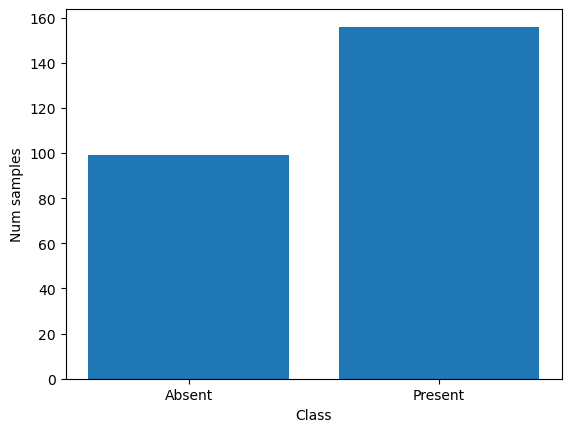

In [9]:
def vis_data_class_distribution(labels, class_names):
    #   labels: list of integers representing the class of each samples
    #   class_names: a list of class names corresponding to each class
    counts = [sum(labels == c) for c in range(len(class_names))]
    # plt.title(f'Data class distribution')
    plt.bar(class_names, counts)
    plt.xlabel('Class')
    plt.ylabel('Num samples')
    plt.show()

vis_data_class_distribution(Train['label'],  classNames)

# Proposed ViT training with Knowledge transfer method

In [12]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

TrainLoader, TestLoader, numClass, classNames = loaddata_mri(root)
Model = torch.load('./saved_models/ViT_src_7_0.pth', map_location=device)
optC = torch.optim.Adam(Model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss() #Define classification loss
print(f'Fine tuning model for traget data: {tarData}')
Model = train_pr(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/ViT_'+tarData+'.pth')

Fine tuning model for traget data: MRI_dataset
Starting Training Loop...
[0/20]   Train Accuracy = 73.92    Val Accuracy = 64.26
[1/20]   Train Accuracy = 88.11    Val Accuracy = 69.12
[2/20]   Train Accuracy = 92.10    Val Accuracy = 82.89
[3/20]   Train Accuracy = 93.40    Val Accuracy = 88.05
[4/20]   Train Accuracy = 98.11    Val Accuracy = 95.33
[5/20]   Train Accuracy = 97.03    Val Accuracy = 96.41
[6/20]   Train Accuracy = 97.42    Val Accuracy = 96.63
[7/20]   Train Accuracy = 96.67    Val Accuracy = 98.49
[8/20]   Train Accuracy = 96.73    Val Accuracy = 96.78
[9/20]   Train Accuracy = 98.61    Val Accuracy = 97.19
[10/20]   Train Accuracy = 98.48    Val Accuracy = 97.10
[11/20]   Train Accuracy = 98.68    Val Accuracy = 97.10
[12/20]   Train Accuracy = 98.37    Val Accuracy = 96.80
[13/20]   Train Accuracy = 98.72    Val Accuracy = 95.69
[14/20]   Train Accuracy = 98.43    Val Accuracy = 95.89
[15/20]   Train Accuracy = 98.58    Val Accuracy = 97.68
[16/20]   Train Accuracy 

Validation Accuracy =  100.0
__________________________________________________
Pricision Score = 1.0
__________________________________________________
F_1 Score =  1.0
__________________________________________________
Recall Score =  1.0
__________________________________________________
Response time per batch 0.25952649116516113


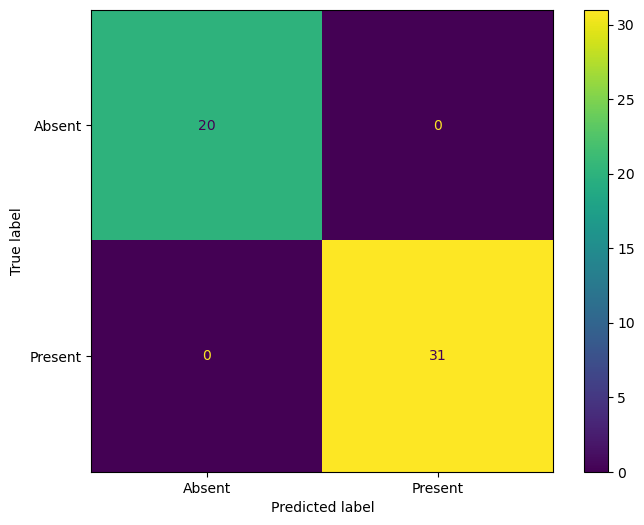

In [13]:
# Validate and Visualize
Model = torch.load('./saved_models/ViT_'+tarData+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate_pr(Model, TestLoader, numClass, task = 'binary')
print('Validation Accuracy = ', 100*val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, classNames)

perfvit = {'Modelname':['ViT_attn'+tarData], 'Val Acc.': 100*val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

# Train benchmark models for comparisions
## Models: Standard ViT, EfficientNet, ResNeXt, DenseNet, VGGNet, GoogleNet, SqeezeNet

### Standard ViT wth 12 encoder block pre-trained in ImageNet1k

In [12]:
TrainLoader, TestLoader, numClass, classNames = loaddata_mri(root)
Model = ViTpretrain(img_size, numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning pre-trained ViT model for traget data: {tarData}')
Model = train(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/ViT_pre_'+tarData+'.pth')

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth
100%|██████████| 331M/331M [00:01<00:00, 220MB/s]


Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 65, 768])
Loaded pretrained weights.
Fine tuning pre-trained ViT model for traget data: MRI_dataset
Starting Training Loop...
[0/20]   Train Accuracy = 71.29    Val Accuracy = 66.67
[1/20]   Train Accuracy = 71.29    Val Accuracy = 72.55
[2/20]   Train Accuracy = 83.17    Val Accuracy = 78.43
[3/20]   Train Accuracy = 89.60    Val Accuracy = 90.20
[4/20]   Train Accuracy = 96.04    Val Accuracy = 78.43
[5/20]   Train Accuracy = 98.51    Val Accuracy = 96.08
[6/20]   Train Accuracy = 99.01    Val Accuracy = 92.16
[7/20]   Train Accuracy = 100.00    Val Accuracy = 92.16
[8/20]   Train Accuracy = 100.00    Val Accuracy = 88.24
[9/20]   Train Accuracy = 100.00    Val Accuracy = 94.12
[10/20]   Train Accuracy = 100.00    Val Accuracy = 98.04
[11/20]   Train Accuracy = 100.00    Val Accuracy = 84.31
[12/20]   Train Accuracy = 98.51    Val Accuracy = 68.63
[13/20]   Train Accuracy = 98.02    Val Accuracy = 80.39
[1

Validation Accuracy =  100.0
__________________________________________________
Pricision Score = 1.0
__________________________________________________
F_1 Score =  1.0
__________________________________________________
Recall Score =  1.0
__________________________________________________
Response time per batch
 0.009930849075317383


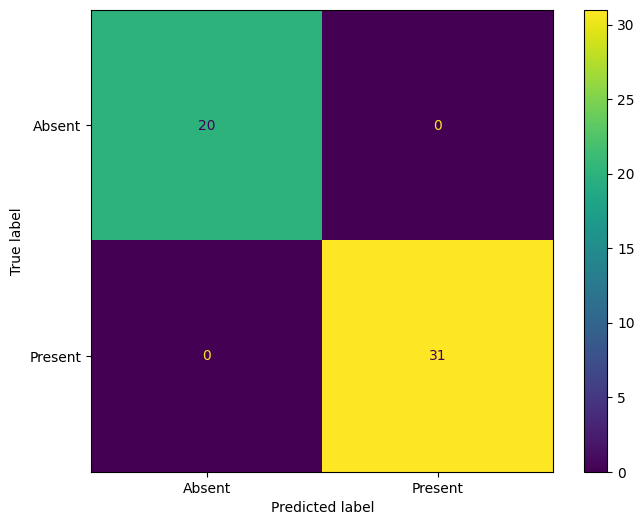

In [10]:
# Validate and Visualize
perfvit_pre = pd.DataFrame({'Metrics':['Val Acc.', 'Precision', 'F1_score', 'Recall']})
Model = torch.load('./saved_models/ViT_pre_'+ tarData +'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch\n', time_batch)
disp_conf_matrix(cm, classNames)

perfvit_pre = pd.concat((perfvit_pre, pd.DataFrame({tarData : [val_acc, prec, f1, recall]})), ignore_index = True, axis=1)

### EfficientNet

In [16]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp
Model = EfficientNet.from_pretrained('efficientnet-b1')
Model._fc = EffNetFC(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning EfficentNet model for traget data: {tarData}')
Model = train(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/efficient_'+tarData+'.pth')

Loaded pretrained weights for efficientnet-b1
Fine tuning EfficentNet model for traget data: MRI_dataset
Starting Training Loop...
[0/20]   Train Accuracy = 49.50    Val Accuracy = 58.82
[1/20]   Train Accuracy = 57.92    Val Accuracy = 56.86
[2/20]   Train Accuracy = 57.43    Val Accuracy = 60.78
[3/20]   Train Accuracy = 61.39    Val Accuracy = 66.67
[4/20]   Train Accuracy = 69.31    Val Accuracy = 76.47
[5/20]   Train Accuracy = 76.24    Val Accuracy = 76.47
[6/20]   Train Accuracy = 81.68    Val Accuracy = 84.31
[7/20]   Train Accuracy = 86.14    Val Accuracy = 88.24
[8/20]   Train Accuracy = 91.09    Val Accuracy = 88.24
[9/20]   Train Accuracy = 92.57    Val Accuracy = 88.24
[10/20]   Train Accuracy = 95.05    Val Accuracy = 88.24
[11/20]   Train Accuracy = 96.53    Val Accuracy = 90.20
[12/20]   Train Accuracy = 97.52    Val Accuracy = 90.20
[13/20]   Train Accuracy = 97.52    Val Accuracy = 90.20
[14/20]   Train Accuracy = 98.02    Val Accuracy = 88.24
[15/20]   Train Accuracy

Validation Accuracy =  90.19607843137256
__________________________________________________
Pricision Score = 0.8951863354037267
__________________________________________________
F_1 Score =  0.8994875837603469
__________________________________________________
Recall Score =  0.9104838709677419
__________________________________________________
Response time per batch 0.11295270919799805


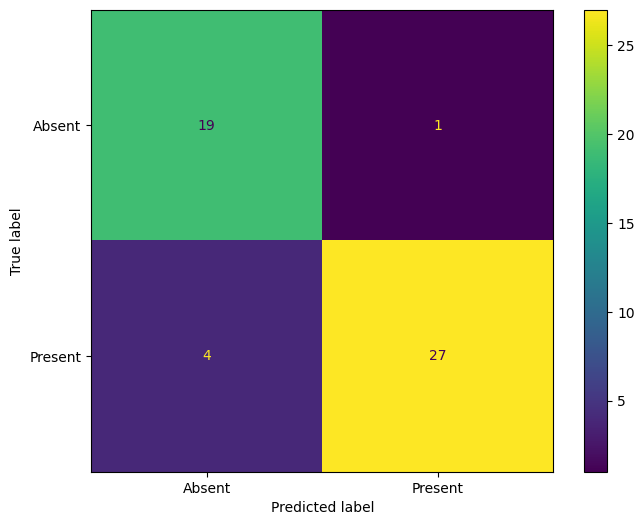

In [11]:
# Validate and Visualize
Model = torch.load('./saved_models/efficient_'+tarData+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, classNames)

perfEffNet = {'Modelname':['EfficientNet_'+tarData], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### ResNeXt

In [19]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

Model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
Model.fc = ResNetFC(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning ResNeXt model for traget data: {tarData}')
Model = train(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/ResNeXt_'+tarData+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: MRI_dataset
Starting Training Loop...
[0/20]   Train Accuracy = 80.69    Val Accuracy = 76.47
[1/20]   Train Accuracy = 87.62    Val Accuracy = 76.47
[2/20]   Train Accuracy = 94.06    Val Accuracy = 86.27
[3/20]   Train Accuracy = 100.00    Val Accuracy = 88.24
[4/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[5/20]   Train Accuracy = 100.00    Val Accuracy = 82.35
[6/20]   Train Accuracy = 99.50    Val Accuracy = 86.27
[7/20]   Train Accuracy = 100.00    Val Accuracy = 88.24
[8/20]   Train Accuracy = 99.01    Val Accuracy = 90.20
[9/20]   Train Accuracy = 98.02    Val Accuracy = 88.24
[10/20]   Train Accuracy = 99.50    Val Accuracy = 88.24
[11/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[12/20]   Train Accuracy = 100.00    Val Accuracy = 92.16
[13/20]   Train Accuracy = 100.00    Val Accuracy = 86.27
[14/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[15/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[16/20] 

Validation Accuracy =  90.19607843137256
__________________________________________________
Pricision Score = 0.9305555555555556
__________________________________________________
F_1 Score =  0.8912579957356077
__________________________________________________
Recall Score =  0.875
__________________________________________________
Response time per batch 0.10659384727478027


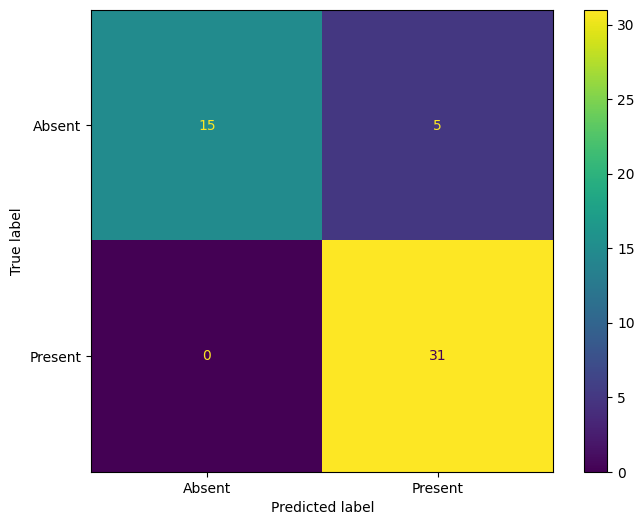

In [12]:
# Validate and Visualize
Model = torch.load('./saved_models/ResNeXt_'+tarData+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, classNames)

perfResNeXt = {'Modelname':['ResNeXt_'+tarData], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### DenseNet

In [21]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

Model = DenseNet(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning DenseNet model for traget data: {tarData}')
Model = train(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/DenseNet_'+tarData+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 79.0MB/s]


Fine tuning DenseNet model for traget data: MRI_dataset
Starting Training Loop...
[0/20]   Train Accuracy = 61.88    Val Accuracy = 86.27
[1/20]   Train Accuracy = 93.07    Val Accuracy = 82.35
[2/20]   Train Accuracy = 95.54    Val Accuracy = 88.24
[3/20]   Train Accuracy = 100.00    Val Accuracy = 88.24
[4/20]   Train Accuracy = 100.00    Val Accuracy = 88.24
[5/20]   Train Accuracy = 100.00    Val Accuracy = 88.24
[6/20]   Train Accuracy = 100.00    Val Accuracy = 88.24
[7/20]   Train Accuracy = 100.00    Val Accuracy = 88.24
[8/20]   Train Accuracy = 100.00    Val Accuracy = 86.27
[9/20]   Train Accuracy = 100.00    Val Accuracy = 86.27
[10/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[11/20]   Train Accuracy = 100.00    Val Accuracy = 92.16
[12/20]   Train Accuracy = 100.00    Val Accuracy = 92.16
[13/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[14/20]   Train Accuracy = 100.00    Val Accuracy = 92.16
[15/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[16

Validation Accuracy =  92.15686274509804
__________________________________________________
Pricision Score = 0.9428571428571428
__________________________________________________
F_1 Score =  0.9141414141414141
__________________________________________________
Recall Score =  0.9
__________________________________________________
Response time per batch 0.09479475021362305


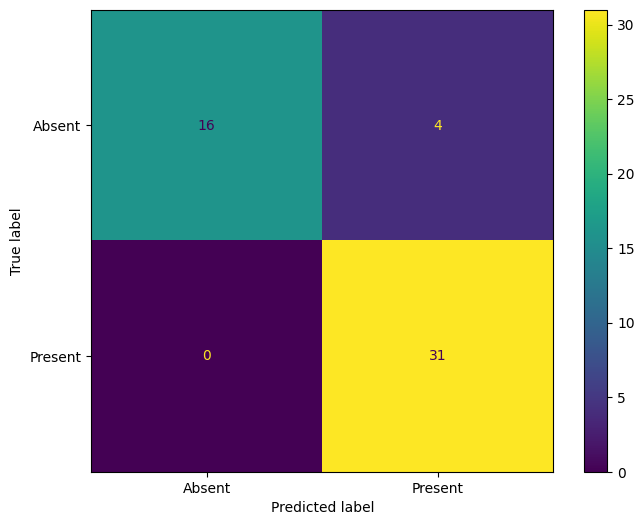

In [13]:
# Validate and Visualize
Model = torch.load('./saved_models/DenseNet_'+tarData+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, classNames)

perfDenseNet = {'Modelname':['DenseNet_'+tarData], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### vgg16Net

In [23]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

Model = vgg16Net(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning vgg16Net model for traget data: {tarData}')
Model = train(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/vgg16Net_'+tarData+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 78.2MB/s]


Fine tuning vgg16Net model for traget data: MRI_dataset
Starting Training Loop...
[0/20]   Train Accuracy = 74.75    Val Accuracy = 70.59
[1/20]   Train Accuracy = 87.62    Val Accuracy = 68.63
[2/20]   Train Accuracy = 90.59    Val Accuracy = 84.31
[3/20]   Train Accuracy = 93.56    Val Accuracy = 90.20
[4/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[5/20]   Train Accuracy = 100.00    Val Accuracy = 82.35
[6/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[7/20]   Train Accuracy = 100.00    Val Accuracy = 88.24
[8/20]   Train Accuracy = 100.00    Val Accuracy = 88.24
[9/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[10/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[11/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[12/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[13/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[14/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[15/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[16/

Validation Accuracy =  90.19607843137256
__________________________________________________
Pricision Score = 0.9117647058823529
__________________________________________________
F_1 Score =  0.8939708939708939
__________________________________________________
Recall Score =  0.8838709677419355
__________________________________________________
Response time per batch 0.018886327743530273


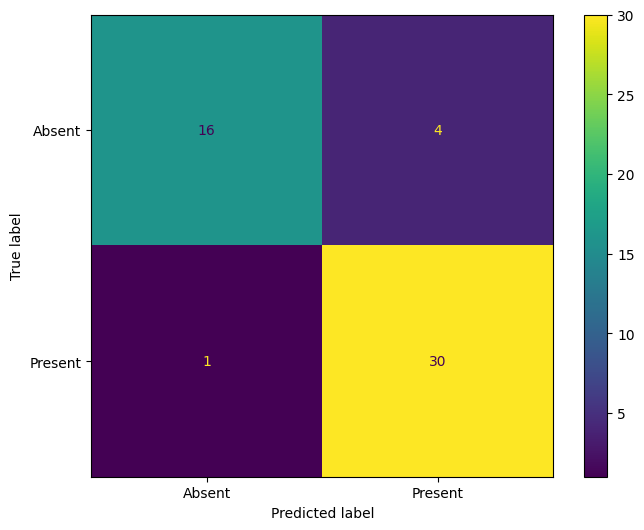

In [14]:
# Validate and Visualize
Model = torch.load('./saved_models/vgg16Net_'+tarData+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, classNames)

perfvgg16Net = {'Modelname':['vgg16Net_'+tarData], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### GoogleNet

In [25]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

Model = googleNet(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning GoogleNet model for traget data: {tarData}')
Model = train(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/GoogleNet_'+tarData+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 74.6MB/s]


Fine tuning GoogleNet model for traget data: MRI_dataset
Starting Training Loop...
[0/20]   Train Accuracy = 48.51    Val Accuracy = 74.51
[1/20]   Train Accuracy = 81.19    Val Accuracy = 76.47
[2/20]   Train Accuracy = 94.06    Val Accuracy = 88.24
[3/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[4/20]   Train Accuracy = 100.00    Val Accuracy = 94.12
[5/20]   Train Accuracy = 100.00    Val Accuracy = 90.20
[6/20]   Train Accuracy = 100.00    Val Accuracy = 94.12
[7/20]   Train Accuracy = 100.00    Val Accuracy = 94.12
[8/20]   Train Accuracy = 100.00    Val Accuracy = 88.24
[9/20]   Train Accuracy = 100.00    Val Accuracy = 92.16
[10/20]   Train Accuracy = 100.00    Val Accuracy = 92.16
[11/20]   Train Accuracy = 100.00    Val Accuracy = 92.16
[12/20]   Train Accuracy = 100.00    Val Accuracy = 94.12
[13/20]   Train Accuracy = 100.00    Val Accuracy = 94.12
[14/20]   Train Accuracy = 100.00    Val Accuracy = 94.12
[15/20]   Train Accuracy = 100.00    Val Accuracy = 94.12
[1

Validation Accuracy =  94.11764705882352
__________________________________________________
Pricision Score = 0.9424342105263157
__________________________________________________
F_1 Score =  0.9377289377289377
__________________________________________________
Recall Score =  0.9338709677419355
__________________________________________________
Response time per batch 0.11208748817443848


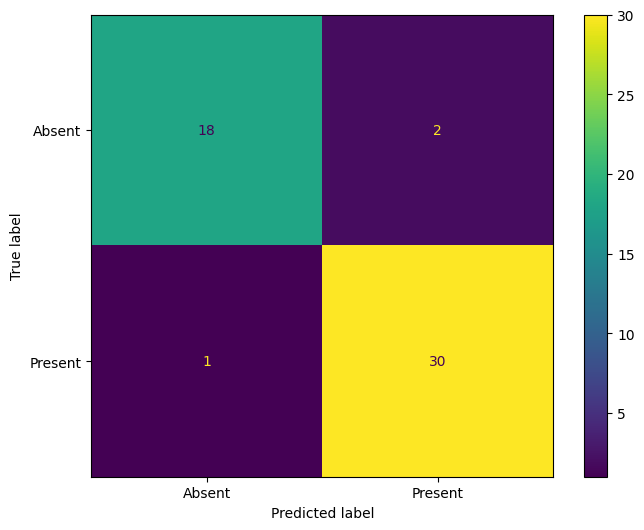

In [15]:
# Validate and Visualize
Model = torch.load('./saved_models/GoogleNet_'+tarData+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, classNames)

perfgoogleNet = {'Modelname':['GoogleNet_'+tarData], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### SqeezeNet

In [27]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

Model = SqeezeNet(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning SqeezeNet model for traget data: {tarData}')
Model = train(Model, TrainLoader, TestLoader, optC, criterion)
torch.save(Model,'./saved_models/SqeezeNet_'+tarData+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 51.9MB/s]


Fine tuning SqeezeNet model for traget data: MRI_dataset
Starting Training Loop...
[0/20]   Train Accuracy = 2.48    Val Accuracy = 31.37
[1/20]   Train Accuracy = 56.44    Val Accuracy = 41.18
[2/20]   Train Accuracy = 66.83    Val Accuracy = 72.55
[3/20]   Train Accuracy = 70.79    Val Accuracy = 64.71
[4/20]   Train Accuracy = 75.74    Val Accuracy = 66.67
[5/20]   Train Accuracy = 79.21    Val Accuracy = 70.59
[6/20]   Train Accuracy = 77.23    Val Accuracy = 72.55
[7/20]   Train Accuracy = 74.75    Val Accuracy = 64.71
[8/20]   Train Accuracy = 80.20    Val Accuracy = 70.59
[9/20]   Train Accuracy = 81.19    Val Accuracy = 68.63
[10/20]   Train Accuracy = 82.67    Val Accuracy = 68.63
[11/20]   Train Accuracy = 82.67    Val Accuracy = 72.55
[12/20]   Train Accuracy = 82.67    Val Accuracy = 74.51
[13/20]   Train Accuracy = 84.16    Val Accuracy = 70.59
[14/20]   Train Accuracy = 83.17    Val Accuracy = 72.55
[15/20]   Train Accuracy = 80.69    Val Accuracy = 76.47
[16/20]   Train 

Validation Accuracy =  76.47058823529412
__________________________________________________
Pricision Score = 0.755050505050505
__________________________________________________
F_1 Score =  0.7483552631578947
__________________________________________________
Recall Score =  0.7443548387096774
__________________________________________________
Response time per batch 0.03511524200439453


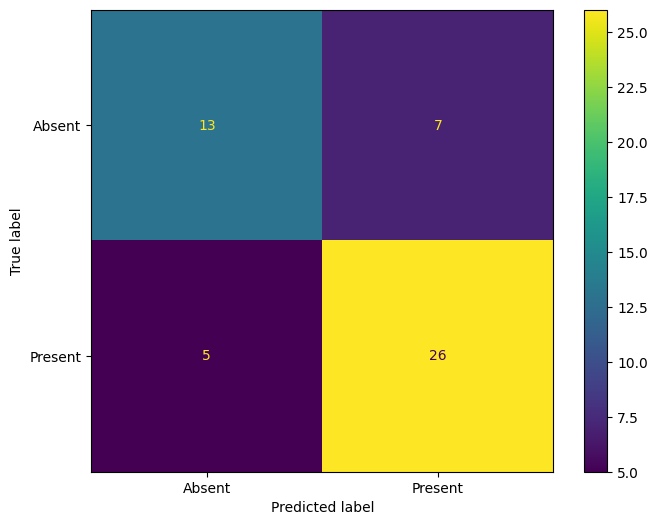

In [16]:
# Validate and Visualize
Model = torch.load('./saved_models/SqeezeNet_'+tarData+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, classNames)

perfSqeezeNet = {'Modelname':['SqeezeNet_'+tarData], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

# **Plot Acc graph**

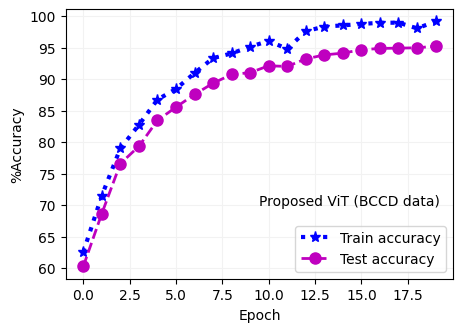

In [ ]:
df = pd.read_excel('train_hisy_vit_prop.xlsx')
fig = plt.figure(figsize=(5,3.5))
plt.plot(df['tr_acc'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_acc'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'])
plt.text(9.5, 70, 'Proposed ViT (BCCD data)')
plt.grid(axis='both', color='0.95')
plt.show()

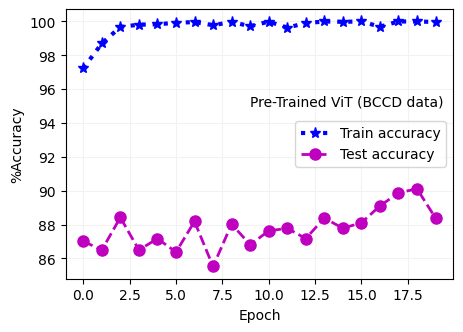

In [ ]:
df = pd.read_excel('train_hisy_vit_pre.xlsx')
fig = plt.figure(figsize=(5,3.5))
plt.plot(df['tr_acc'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_acc'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'])
plt.text(9, 95, 'Pre-Trained ViT (BCCD data)')
plt.grid(axis='both', color='0.95')
plt.show()

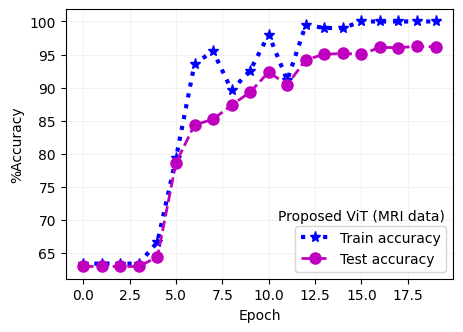

In [ ]:
df = pd.read_excel('train_hisy_vit_prop_MRI.xlsx')
fig = plt.figure(figsize=(5,3.5))
plt.plot(df['tr_acc'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_acc'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'])
plt.text(10.5, 70, 'Proposed ViT (MRI data)')
plt.grid(axis='both', color='0.95')
plt.show()

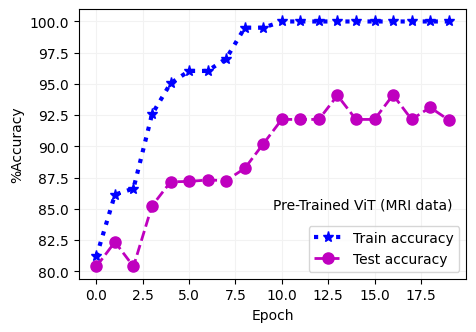

In [ ]:
df = pd.read_excel('train_hisy_vit_pre_MRI.xlsx')
fig = plt.figure(figsize=(5,3.5))
plt.plot(df['tr_acc'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_acc'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'])
plt.text(9.5, 85, 'Pre-Trained ViT (MRI data)')
plt.grid(axis='both', color='0.95')
plt.show()